In [1]:
import osmnx as ox
import pandas as pd
import networkx as nx
from shapely.geometry import Point
from scipy.spatial import cKDTree
import geopandas as gpd

In [2]:
G = ox.load_graphml("../data/chengdu_road_network.graphml")
nodes, edges = ox.graph_to_gdfs(G)

In [3]:
# Get the number of nodes and edges in the graph
print("Number of nodes:", len(nodes))
print("Number of edges:", len(edges))

Number of nodes: 106957
Number of edges: 258601


In [4]:
def read_csv_range(format_list, file_pattern = "../data/chengdu/201408{:02d}.csv"):
    """
    Reads multiple CSV files from the specified range and appends them into a single DataFrame.

    Parameters:
        file_pattern (str): The file path pattern, e.g., .
        start (int): The starting day.
        end (int): The ending day.

    Returns:
        gpd.GeoDataFrame: Combined GeoDataFrame.
    """
    frames = []
    for day in format_list:
        file_path = file_pattern.format(day)
        df = pd.read_csv(file_path)
        df['geometry'] = gpd.points_from_xy(df['Lng'], df['Lat'])
        frames.append(df)
    combined_df = pd.concat(frames, ignore_index=True)
    return gpd.GeoDataFrame(combined_df, geometry='geometry', crs="EPSG:4326"), len(format_list)

In [5]:
# Read and combine the CSV files
format_list_simple = [3, 4, 5]
format_list_full = [3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 22, 23]
gdf, n_days = read_csv_range(format_list_simple, "../data/chengdu/201408{:02d}.csv")

In [6]:
#获取道路中心点
edges['midpoint'] = edges.geometry.apply(lambda geom: geom.interpolate(0.5,normalized=True))
midpoints = list(zip(edges.midpoint.x,edges.midpoint.y))

/opt/homebrew/anaconda3/envs/nlp/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


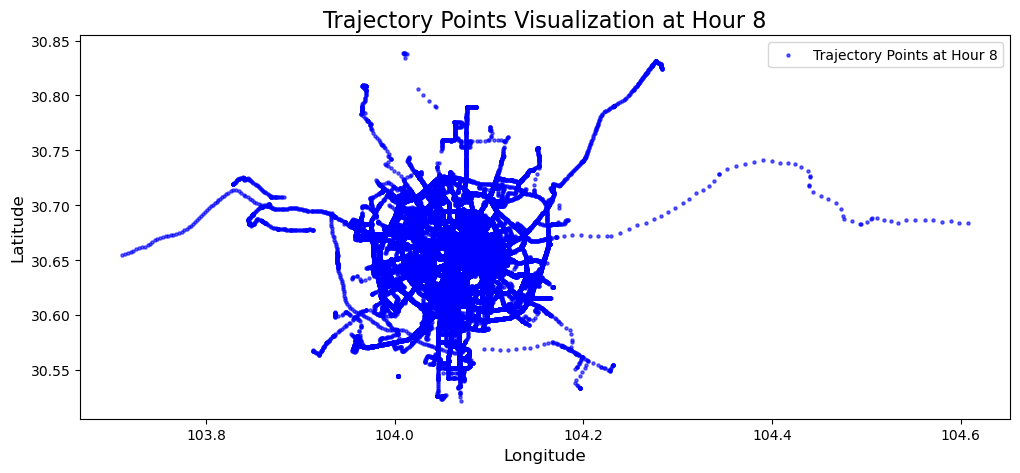

In [16]:
def visualize_trajectory_points(gdf, hour):
    """
    Visualizes all trajectory points for a specific hour on a 2D map.

    Parameters:
        gdf (gpd.GeoDataFrame): The GeoDataFrame containing trajectory points.
        hour (int): The hour to filter and visualize points.

    Returns:
        None
    """
    # Drop rows where Status is 0
    gdf = gdf[gdf['Status'] != 0]

    # Ensure the 'Hour' column is correctly parsed from the 'Time' column
    gdf['Hour'] = pd.to_datetime(gdf['Time']).dt.hour

    # Filter trajectory points by the specified hour
    hourly_points = gdf[gdf['Hour'] == hour]

    # Create a plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot the trajectory points
    hourly_points.plot(ax=ax, marker='o', color='blue', markersize=5, alpha=0.6, label=f'Trajectory Points at Hour {hour}')

    # Enhance plot with titles and labels
    ax.set_title(f'Trajectory Points Visualization at Hour {hour}', fontsize=16)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.legend()

    # Show the plot
    plt.show()

# Example usage: Visualize trajectory points at hour 14
visualize_trajectory_points(gdf, 8)


DBSCAN Cluster 来预测流量的效果并不好 我直接否了，这里的两个代码block不用跑

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import DBSCAN
import numpy as np

# eps = 0.001
# min_samples = 10

# # Extract coordinates for clustering
# coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))

# # Apply DBSCAN clustering
# db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
# gdf['cluster'] = db.labels_

In [ ]:
# # Create a plot
# fig, ax = plt.subplots(figsize=(12, 8))

# # Plot clusters
# unique_clusters = gdf['cluster'].unique()
# for cluster in unique_clusters:
#     if cluster == -1:
#         # Noise points
#         cluster_points = gdf[gdf['cluster'] == cluster]
#         cluster_points.plot(ax=ax, marker='x', color='gray', markersize=5, alpha=0.5, label='Noise')
#     else:
#         cluster_points = gdf[gdf['cluster'] == cluster]
#         cluster_points.plot(ax=ax, marker='o', alpha=0.6, markersize=5, label=f'Cluster {cluster}')

#     # Enhance plot with titles and labels
#     ax.set_title('DBSCAN Clustering of Trajectory Points', fontsize=20)
#     ax.set_xlabel('Longitude', fontsize=15)
#     ax.set_ylabel('Latitude', fontsize=15)

#     # Show the plot
#     plt.show()

In [26]:
from geopy.distance import geodesic

def calculate_velocity(df):
    """
    Calculate velocity for trajectory points based on GPS coordinates and time.

    Parameters:
        df (pd.DataFrame): The DataFrame containing trajectory data with 'Lat', 'Lng', 'Status', and 'Time'.

    Returns:
        pd.DataFrame: DataFrame with an additional 'Velocity' column.
    """
    # Ensure 'Time' is in datetime format
    df['Time'] = pd.to_datetime(df['Time'])

    # Initialize velocity column
    df['Velocity'] = 0.0

    # Group by VehicleNum to process each trajectory separately
    grouped = df.groupby('VehicleNum')

    for vehicle, group in grouped:
        group = group.sort_values('Time').reset_index(drop=True)

        start_idx, end_idx = None, None

        for i in range(1, len(group)):
            if group.loc[i - 1, 'Status'] == 0 and group.loc[i, 'Status'] == 1:
                start_idx = i
            if group.loc[i - 1, 'Status'] == 1 and group.loc[i, 'Status'] == 0:
                end_idx = i

            if start_idx is not None and end_idx is not None:
                # Set velocity to zero at start and end points
                group.loc[start_idx, 'Velocity'] = 0.0
                group.loc[end_idx, 'Velocity'] = 0.0

                # Calculate velocity for intermediate points
                for j in range(start_idx + 1, end_idx):
                    point1 = (group.loc[j - 1, 'Lat'], group.loc[j - 1, 'Lng'])
                    point2 = (group.loc[j, 'Lat'], group.loc[j, 'Lng'])
                    distance_km = geodesic(point1, point2).kilometers
                    time_elapsed = (group.loc[j, 'Time'] - group.loc[j - 1, 'Time']).total_seconds() / 3600.0
                    group.loc[j, 'Velocity'] = distance_km / time_elapsed if time_elapsed > 0 else 0.0

                start_idx, end_idx = None, None

        # Write back processed group
        df.update(group)

    return df

In [80]:
gdf_velo, n_ = read_csv_range(format_list_full, "../data/chengdu/201408{:02d}.csv")

In [81]:
gdf_velo = calculate_velocity(gdf_velo)

Show velocity with different intervals (Deprecated)

In [ ]:
# Filter for status = 1 points only
gdf_velo_visual = gdf_velo[gdf_velo['Status'] == 1]

# Define velocity intervals
intervals = [(0.001, 10), (10, 20), (20, 40), (40, 80), (80, float('inf'))]
colors = ['blue', 'green', 'orange', 'red', 'purple']

# Create a plot
fig, ax = plt.subplots(figsize=(12, 8))

for (vmin, vmax), color in zip(intervals, colors):
    subset = gdf_velo_visual[(gdf_velo_visual['Velocity'] >= vmin) & (gdf_velo_visual['Velocity'] < vmax)]
    ax.scatter(subset['Lng'], subset['Lat'], s=10, c=color, label=f'{vmin}-{vmax} km/h', alpha=0.6)

# Enhance plot with titles and labels
ax.set_title('Velocity Intervals Visualization', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.legend(title='Velocity (km/h)', fontsize=10)

# Show the plot
plt.show()

Visualize slow points below 20 (Deprecated)

In [ ]:
# Filter for status = 1 points only
# Define velocity intervals
intervals = [(0.001, 20), (20, 30), (20, 30)]
colors = ['red', 'orange', 'yellow']

# Create a plot
fig, ax = plt.subplots(figsize=(12, 8))

for (vmin, vmax), color in zip(intervals, colors):
    subset = gdf_velo_visual[(gdf_velo_visual['Velocity'] >= vmin) & (gdf_velo_visual['Velocity'] < vmax)]
    ax.scatter(subset['Lng'], subset['Lat'], s=10, c=color, label=f'{vmin}-{vmax} km/h', alpha=0.6)

# Enhance plot with titles and labels
ax.set_title('Velocity Intervals Visualization', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.legend(title='Velocity (km/h)', fontsize=10)

# Show the plot
plt.show()

Visualization conjestion points by hours

/opt/homebrew/anaconda3/envs/nlp/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


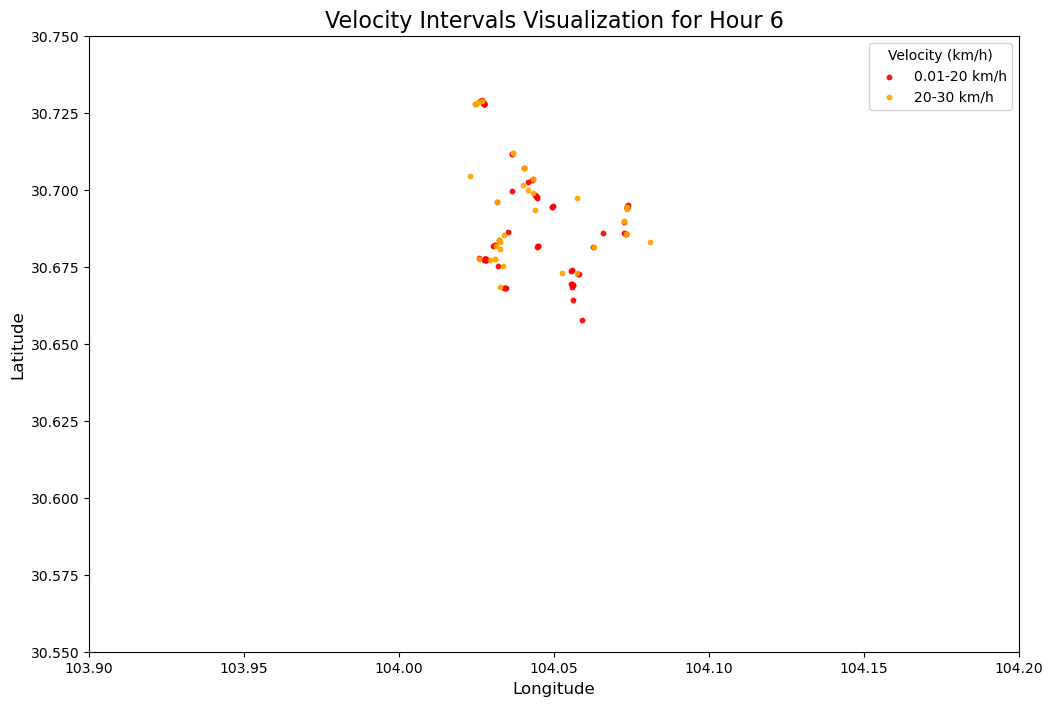

In [87]:
def visualize_velocity_intervals(df, hour=None):
    """
    Visualize velocity distribution on a 2D map, grouped into intervals and optionally filtered by hour.

    Parameters:
        df (pd.DataFrame): DataFrame containing trajectory data with 'Lat', 'Lng', 'Velocity', and 'Status'.
        hour (int, optional): Specific hour to filter points for visualization. Defaults to None (no filtering).

    Returns:
        None
    """
    df = df[(df['Lng'] >= 103.90) & (df['Lng'] <= 104.20) & (df['Lat'] >= 30.50) & (df['Lat'] <= 30.80)]

    # Filter by hour if provided
    if hour is not None:
        df['Hour'] = pd.to_datetime(df['Time']).dt.hour
        df = df[df['Hour'] == hour]

    # Define velocity intervals
    # intervals = [(0.01, 20), (20, 30), (30, 45), (45, float('inf'))]
    intervals = [(0.01, 20), (20, 30)]
    colors = ['red', 'orange', 'yellow', "green"]

    # Create a plot
    fig, ax = plt.subplots(figsize=(12, 8))

    for (vmin, vmax), color in zip(intervals, colors):
        subset = df[(df['Velocity'] >= vmin) & (df['Velocity'] < vmax)]
        ax.scatter(subset['Lng'], subset['Lat'], s=10, c=color, label=f'{vmin}-{vmax} km/h', alpha=0.9)

    # Enhance plot with titles and labels
    title = 'Velocity Intervals Visualization'
    if hour is not None:
        title += f' for Hour {hour}'
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_xlim(103.90, 104.20)
    ax.set_ylim(30.55, 30.75)
    ax.legend(title='Velocity (km/h)', fontsize=10)

    # Show the plot
    plt.show()

visualize_velocity_intervals(gdf_velo_visual, hour = 6)


可以看到六点完全不堵 看看后面8点的 路网上面全是拥堵点 后续如果有时间可以路网画出来 然后把这些点给标上去

/opt/homebrew/anaconda3/envs/nlp/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


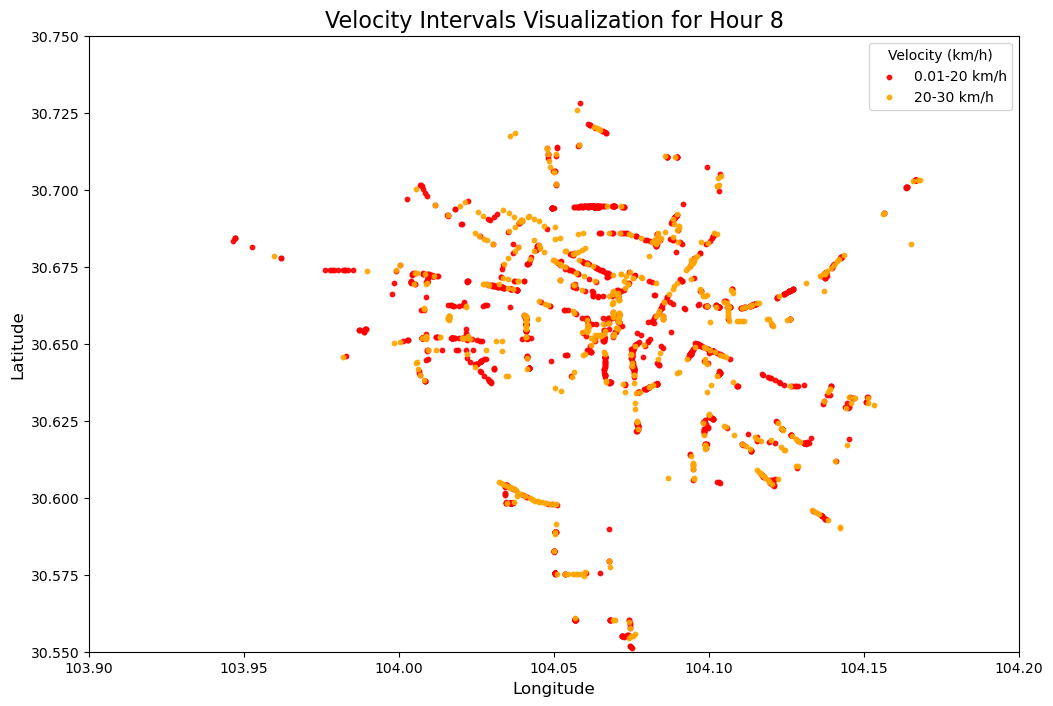

In [98]:
visualize_velocity_intervals(gdf_velo_visual, hour = 8)

我这里的想法是把速度作为一个特征加到我们的模型里面，然而在预测时间的时候，我们无法对于每一个轨迹的采样点获得速度信息，所以需要一个速度的预测模型来做这一工作。

流量预测模型目前最好的就是ST—GCN和HST-GCN，为了测试用速度作为第三个特征（预测的时候放3-d）是否work，我想先测试以下方案：
1. 我们分离出两个模型，一个用于预测轨迹的速度，第二个模型调用第一个模型的速度特征，拼接成三维向量进行预测
2. 直接用多任务学习，用一个模型预测两个内容，先用自回归损失预测速度token，之后用MSELoss把最后一个token的输出进行优化

我们先来尝试一下第一个方案，我想速度预测（或者叫生成）的部分用序列模型/自回归损失来做，上面的代码已经算出了一个观测点的真实速度，我们起始位置输入三个特征：start token的lat和lng，加上一个0速度，每一个时间戳计算一个速度，然后加入到下一个时间戳的特征，损失函数就是每一个点的MSELoss累加之后除掉总token的长度

In [100]:
print(len(gdf_velo))

14180471


先把单个点转成轨迹数据，由于我们需要加入时序的特征，所以我打算把小时替换成秒，让模型自己去学

In [101]:
gdf_velo.head(5)

,VehicleNum,Lat,Lng,Status,Time,geometry,Velocity
0,200,30.686755,104.100249,0,2014-08-03 06:00:10,POINT (104.10025 30.68676),0.0
1,200,30.686755,104.100249,0,2014-08-03 06:00:41,POINT (104.10025 30.68676),0.0
2,200,30.686755,104.100249,0,2014-08-03 06:01:11,POINT (104.10025 30.68676),0.0
3,200,30.686755,104.100249,0,2014-08-03 06:01:42,POINT (104.10025 30.68676),0.0
4,200,30.686755,104.100249,0,2014-08-03 06:02:13,POINT (104.10025 30.68676),0.0


In [102]:
def convert_time_to_seconds(df):
    """
    Convert the time column into seconds since the start of the day.

    Parameters:
        df (pd.DataFrame): DataFrame containing a 'Time' column.

    Returns:
        pd.DataFrame: DataFrame with an additional 'time_second' column.
    """
    # Ensure 'Time' is in datetime format
    df['Time'] = pd.to_datetime(df['Time'])

    # Calculate seconds since the start of the day
    df['time_second'] = df['Time'].dt.hour * 3600 + df['Time'].dt.minute * 60 + df['Time'].dt.second

    return df

In [103]:
gdf_velo = convert_time_to_seconds(gdf_velo)

In [104]:
gdf_velo.head(5)

,VehicleNum,Lat,Lng,Status,Time,geometry,Velocity,time_second
0,200,30.686755,104.100249,0,2014-08-03 06:00:10,POINT (104.10025 30.68676),0.0,21610
1,200,30.686755,104.100249,0,2014-08-03 06:00:41,POINT (104.10025 30.68676),0.0,21641
2,200,30.686755,104.100249,0,2014-08-03 06:01:11,POINT (104.10025 30.68676),0.0,21671
3,200,30.686755,104.100249,0,2014-08-03 06:01:42,POINT (104.10025 30.68676),0.0,21702
4,200,30.686755,104.100249,0,2014-08-03 06:02:13,POINT (104.10025 30.68676),0.0,21733


In [112]:
feature = ['Lng', 'Lat', 'Velocity']

def convert_to_traj(df, feature):
    results = []
    grouped = df.groupby('VehicleNum')
    # 存储单日结果的列表
    daily_results = []
    for vehicle, group in grouped:
        group = group.reset_index(drop=True)
        start_idx = None

        for i in range(len(group)):
            if group.loc[i, 'Status'] == 1 and start_idx is None:
                start_idx = i
            elif group.loc[i, 'Status'] == 0 and start_idx is not None:
                trajectory = group.loc[start_idx:i, feature].values.tolist()
                start_time = group.loc[start_idx, 'time_second']
                end_time = group.loc[i, 'time_second']
                time_elapsed = end_time - start_time
                if time_elapsed >= 600 and time_elapsed <= 3000:
                    daily_results.append({
                        "VehicleNum": vehicle,
                        "trajectory": trajectory,
                        "start_time": start_time,
                        "end_time": end_time,
                        "time_elapsed": time_elapsed
                    })

                start_idx = None
    results.extend(daily_results)

    results_df = pd.DataFrame(results)
    return results_df

In [113]:
gdf_velo_predict = gdf_velo.copy()

convert_to_traj(gdf_velo_predict, feature)

,VehicleNum,trajectory,start_time,end_time,time_elapsed
0,1,"[[104.057363, 30.69315, 0.0], [104.057363, 30....",23518,25087,1569
1,1,"[[104.124865, 30.605235, 0.0], [104.124745, 30...",25653,27036,1383
2,1,"[[104.058942, 30.680353, 0.0], [104.063278, 30...",27349,28713,1364
3,1,"[[104.123902, 30.672119, 0.0], [104.124228, 30...",29197,30618,1421
4,1,"[[104.084762, 30.647605, 0.0], [104.085446, 30...",31465,32213,748
...,...,...,...,...,...
72338,200,"[[104.035466, 30.678799, 0.0], [104.035634, 30...",78478,79809,1331
72339,200,"[[104.077765, 30.65829, 0.0], [104.077982, 30....",79840,80818,978
72340,200,"[[104.048964, 30.677632, 0.0], [104.049303, 30...",80870,81541,671
72341,200,"[[104.068975, 30.660381, 0.0], [104.068973, 30...",81876,82644,768
